In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone.utils.torch import FiftyOneTorchDataset

In [2]:
import utils

In [3]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import torchvision.transforms.v2 as transforms
from torchvision import tv_tensors
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patches
from PIL import Image


In [4]:
torch.multiprocessing.set_start_method('forkserver')

# Load Dataset

In [5]:
dataset = foz.load_zoo_dataset("quickstart", overwrite=True)

Overwriting existing directory '/home/jacobs/fiftyone/quickstart'
 100% |████|  187.5Mb/187.5Mb [205.8ms elapsed, 0s remaining, 911.3Mb/s]      
Extracting dataset...
Parsing dataset metadata
Found 200 samples
Dataset info written to '/home/jacobs/fiftyone/quickstart/info.json'
Loading existing dataset 'quickstart'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [6]:
# make sure it's persistent
print(dataset.persistent)

# if it's not, set this variable to True
if not dataset.persistent:
    dataset.persistent = True

True


# Do Your Data Centric Work

In [7]:
some_interesting_view = dataset.take(100)

# Transferring to a Torch Dataset and the `get_item` Argument

In order to transfer to a torch dataset, we most provide a function that transforms FiftyOne Samples into input for the model. We pass this function with the `get_item` argument. Let's start with a very simple example that will help us understand what's happening.

In [8]:
# to best understand what's happening, let's first pass the identity function
def get_item_identity(x):
    return x

In [9]:
torch_dataset = some_interesting_view.to_torch(get_item_identity)

In [10]:
result = torch_dataset[0]
print(type(result))
print(result['id'])
print(result['filepath'])

<class 'fiftyone.core.sample.Sample'>
67be7705acd35912dc493b1e
/home/jacobs/fiftyone/quickstart/data/001312.jpg


The `get_item` function can be anything that accepts a fiftyone Sample. Here is a simple example:

In [11]:
def simple_get_item(sample):
    return sample['id']

In [12]:
torch_datset = some_interesting_view.to_torch(simple_get_item)

In [13]:
# torch_dataset is now a fully functional torch_dataset.
print(torch_datset[0])

67be7705acd35912dc493b1e


In [14]:
# torch_dataset has the same exact samples as some_interesting_view, down to the order.
assert [res for res in torch_datset] == some_interesting_view.values('id')

# Write an actual `get_item` function

In [15]:
# let's write a standard detection get_item
augmentations = transforms.Compose([
    transforms.CenterCrop(512),
    transforms.ClampBoundingBoxes()
])
def get_item(sample):
    res = {}
    image = Image.open(sample['filepath'])
    og_wh = np.array([image.width, image.height])
    image = tv_tensors.Image(image)
    detections = sample['ground_truth.detections']
    if detections is None:
        detections = []
    detections_tensor = torch.tensor([detection['bounding_box'] for detection in detections]) if len(detections)>0 \
        else torch.zeros((0,4))
    res['box'] = tv_tensors.BoundingBoxes(detections_tensor * torch.tensor([*og_wh, *og_wh]),
        format=tv_tensors.BoundingBoxFormat('XYWH'),
        canvas_size=image.shape[-2:]
    ) 
    res['label'] = [detection['label'] for detection in detections]
    res['id'] = sample['id']
    image, res = augmentations(image, res)
    return image, res

# Visualizing the result

In [16]:
# This is also a good opprotunity to debug your get_item in case you need to

In [17]:
torch_dataset = some_interesting_view.to_torch(get_item)

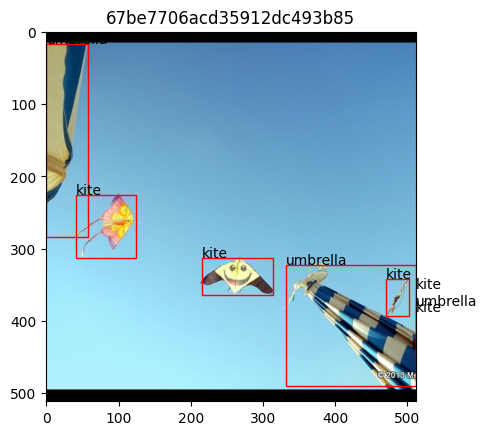

In [18]:
# run this a couple of times to look through samples in the dataset
random_index = np.random.randint(0, len(torch_dataset))
image, res = torch_dataset[random_index]
plt.title(res['id'])
plt.imshow(image.permute(1, 2, 0).numpy())
axes = plt.gca()
for b, l in zip(res['box'], res['label']):
    rect = plt_patches.Rectangle((b[0], b[1]),
                                    b[2], b[3],
                                    linewidth=1, edgecolor='r', facecolor='none')
    axes.add_patch(rect)
    axes.annotate(l, rect.get_xy())
plt.show()

# Creating a DataLoader

FiftyOneTorchDatasets are compatible with torch DataLoaders, and can be used during training. Here is how you can create a DataLoader:

In [19]:
# We need a new dataset object here. Once we've already sampled from the previous one, we have opened up a DB connection
# making the object unpickleable, and not suitable for multiproccessing use.

# utils.get_item_quickstart is the same get_item as above.
torch_dataset = some_interesting_view.to_torch(utils.get_item_quickstart)
"""
The code we are runnig is as follows:
def simple_collate_fn(batch):
    return tuple(zip(*batch))
def create_dataloader_simple(torch_dataset):
    dataloader = torch.utils.data.DataLoader(torch_dataset,
                                             batch_size=5,
                                             shuffle=True,
                                             num_workers=2, # we are compatible with many workers
                                             worker_init_fn=FiftyOneTorchDataset.worker_init, # this is required for the dataloader to work
                                             collate_fn=simple_collate_fn)

We are running it from a seperate file because Jupyter Notebooks are not compatible with the 'spawn' and 'forkserver' start methods
for code that is written *in* the notebook.
"""
dataloader = utils.create_dataloader_simple(torch_dataset)

In [20]:
"""
Code we are running:
def ids_in_dataloader(dataloader):
    # we can iterate over the dataset like this:
    ids_seen = []
    for images, results in dataloader:
        assert len(images) == 5 # we are actually getting a batch of 5
        ids_seen += [results[i]['id'] for i in range(len(results))]
    return ids_seen
"""
ids_seen = utils.ids_in_dataloader(dataloader)

In [21]:
# confirm we have seen each sample once
from collections import Counter
ids_with_counts = Counter(ids_seen)
assert set(ids_with_counts.keys()) == set(some_interesting_view.values('id'))
assert np.all(np.array(list(ids_with_counts.values())) == 1)

In [22]:
# visualizing results, run this a couple of times to see different batches
iterator = iter(dataloader)

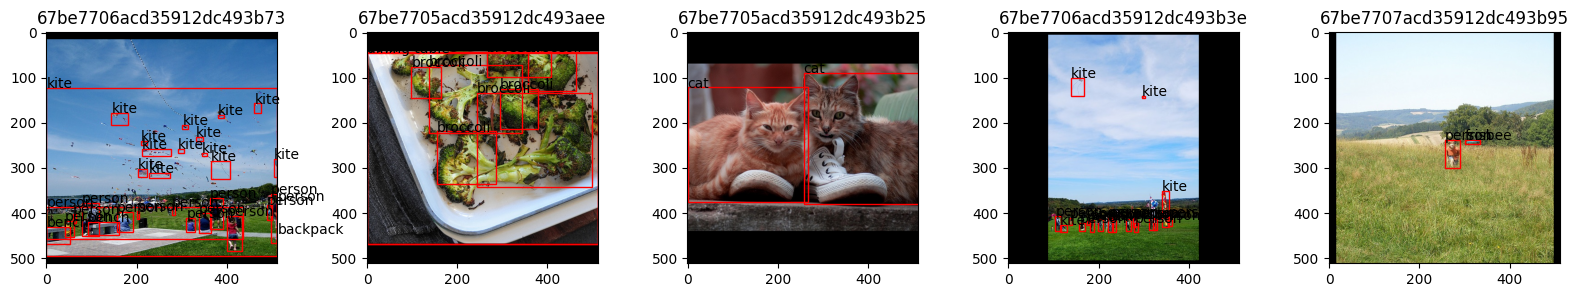

In [23]:
image, res = next(iterator)

fig, axes = plt.subplots(1, len(image), figsize=(4 * len(image), 3))

for i, img in enumerate(image):
    axes[i].set_title(res[i]['id'])
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    for b, l in zip(res[i]['box'], res[i]['label']):
        rect = plt_patches.Rectangle((b[0], b[1]),
                                        b[2], b[3],
                                        linewidth=1, edgecolor='r', facecolor='none')
        axes[i].add_patch(rect)
        axes[i].annotate(l, rect.get_xy())

plt.show()